In [1311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1312]:
# 리눅스 한글 설정
plt.rc('font', family = 'NanumGothic')

In [1313]:
file_1 = '한국 lstm 기온데이터.csv'

In [1314]:
df1 = pd.read_csv(file_1, encoding = 'UTF-8')

In [1315]:
df1.head()

,지점,지점명,일시,평균기온(℃)
0,105,강릉,2013-01-01,-1.9
1,105,강릉,2013-01-02,-6.0
2,105,강릉,2013-01-03,-7.5
3,105,강릉,2013-01-04,-4.9
4,105,강릉,2013-01-05,-1.7


In [1316]:
df_korea = df1.drop(['지점', '지점명'], axis = 1).groupby(['일시']).mean()
df_korea.head()

,평균기온(℃)
일시,
2013-01-01,-0.76250
2013-01-02,-4.70000
2013-01-03,-8.09375
2013-01-04,-6.74375
2013-01-05,-3.81250


In [1317]:
df_korea.tail()

,평균기온(℃)
일시,
2023-08-06,29.40625
2023-08-07,29.28750
2023-08-08,29.08125
2023-08-09,26.48125
2023-08-10,23.74375


((array([-3.56938978, -3.32997769, -3.19781246, ...,  3.19781246,
          3.32997769,  3.56938978]),
  array([-10.50625,  -9.90625,  -9.3625 , ...,  30.73125,  30.75   ,
          30.81875])),
 (9.091209558499642, 14.312004495783857, 0.9809645531634142))

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


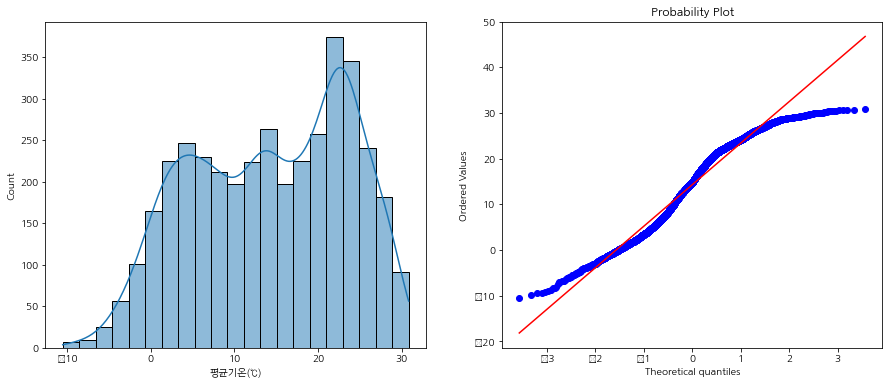

In [1318]:
# 우선 종속변수의 분포를 확인

fig, axes = plt.subplots(1,2, figsize = (15,6))

sns.histplot(df_korea['평균기온(℃)'], ax =axes[0], kde=True)
stats.probplot(df_korea["평균기온(℃)"], dist='norm', fit=True, plot=axes[1])


# 오른쪽 파란색 곡선이 빨간색 직선에 비슷해 질수록 정규분포를 따른다 ==> 그다지 정확하지는 않지만, 얼추 따른다고 생각

## 기온데이터만 가지고 예측 모델 만들기
#### 월별에서 일별이 되었을 때, 할 수 있는 것이 무엇이 있을까?
#### 1. <span style='background-color:#fff5b1'>1 ~ 6일의 기온으로 다음 7일을 예측하는 모델을 만들자는 생각</span>
#### 2. 2022년까지의 데이터를 가지고 2023년 1년을 에측하는 모델을 만들어보자
#### 2-1. train data = 2013 ~ 2022, test data = 2023
#### 3. 일단 train 및 test 일별데이터가 어떻게 분포하는지 시각화 필요

In [1319]:
# train, test 나누기
real_data = df_korea.loc['2023-01-01':, '평균기온(℃)']
train_data = df_korea.loc[:'2022-12-31', '평균기온(℃)']
train_data, real_data

(일시
 2013-01-01   -0.76250
 2013-01-02   -4.70000
 2013-01-03   -8.09375
 2013-01-04   -6.74375
 2013-01-05   -3.81250
                ...   
 2022-12-27    0.31250
 2022-12-28    0.16250
 2022-12-29   -0.51250
 2022-12-30    0.53125
 2022-12-31    1.05625
 Name: 평균기온(℃), Length: 3652, dtype: float64,
 일시
 2023-01-01     1.88125
 2023-01-02    -0.58750
 2023-01-03    -1.09375
 2023-01-04     0.63750
 2023-01-05     1.57500
                 ...   
 2023-08-06    29.40625
 2023-08-07    29.28750
 2023-08-08    29.08125
 2023-08-09    26.48125
 2023-08-10    23.74375
 Name: 평균기온(℃), Length: 222, dtype: float64)

In [1320]:
temp_train = train_data.reset_index()
temp_real = real_data.reset_index()

In [1321]:
temp_train['일시'] = pd.to_datetime(temp_train['일시'])

In [1322]:
temp_real['일시'] =  pd.to_datetime(temp_real['일시'])

Text(0.5, 1.0, 'train data : 대한민국 국내 기온 변화 (2013-01-01 ~ 2022-12-31)')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


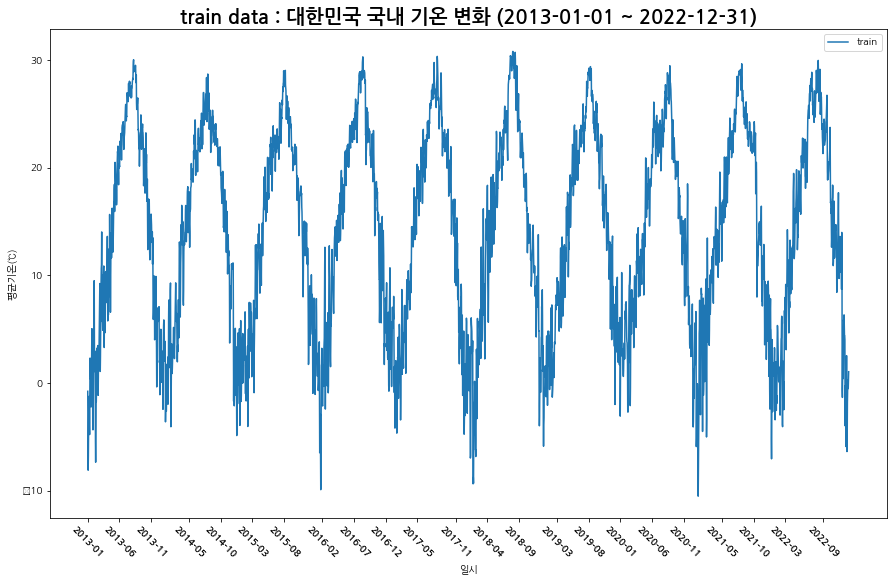

In [1323]:
fig, axe = plt.subplots(figsize = (15,9))
window = 10
sns.lineplot(x = temp_train['일시'], y = temp_train['평균기온(℃)'], label = 'train')
axe.set_xticks(temp_train['일시'].dt.strftime('%Y-%m').iloc[window::160])
axe.set_xticklabels(temp_train['일시'].dt.strftime('%Y-%m').iloc[window::160], rotation = -45, weight='bold')
axe.set_title('train data : 대한민국 국내 기온 변화 (2013-01-01 ~ 2022-12-31)', fontsize = 20, weight='bold')

Text(0.5, 1.0, 'test data : 대한민국 국내 기온 변화 (2023-01-01 ~ 2023-08-10)')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


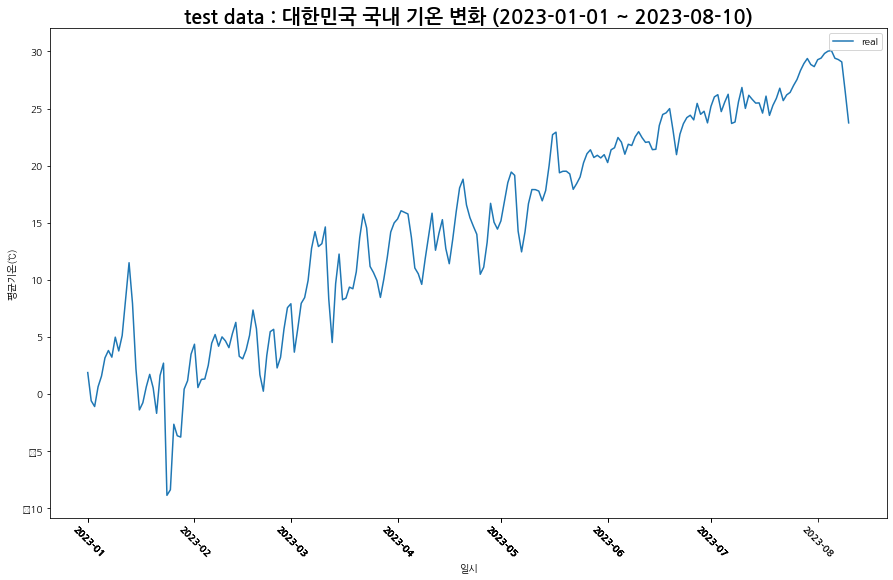

In [1324]:
fig, axe = plt.subplots(figsize = (15,9))
window = 10
sns.lineplot(x = temp_real['일시'], y = temp_real['평균기온(℃)'], label = 'real')
axe.set_xticks(temp_real['일시'].dt.strftime('%Y-%m').iloc[window::10])
axe.set_xticklabels(temp_real['일시'].dt.strftime('%Y-%m').iloc[window::10], rotation = -45, weight='bold')
axe.set_title('test data : 대한민국 국내 기온 변화 (2023-01-01 ~ 2023-08-10)', fontsize = 20, weight='bold')

In [1325]:
temp_train

,일시,평균기온(℃)
0,2013-01-01,-0.76250
1,2013-01-02,-4.70000
2,2013-01-03,-8.09375
3,2013-01-04,-6.74375
4,2013-01-05,-3.81250
...,...,...
3647,2022-12-27,0.31250
3648,2022-12-28,0.16250
3649,2022-12-29,-0.51250
3650,2022-12-30,0.53125


In [1326]:
train = list(temp_train['평균기온(℃)'])
train = {0 : train}
train = pd.DataFrame(train)
print(train)

            0
0    -0.76250
1    -4.70000
2    -8.09375
3    -6.74375
4    -3.81250
...       ...
3647  0.31250
3648  0.16250
3649 -0.51250
3650  0.53125
3651  1.05625

[3652 rows x 1 columns]


In [1327]:
def maketimeSeries(df, n_in = 6):
    for i in range(1, n_in+1):
        df[i] = df[i-1].shift(1)
    return df

In [1328]:
train = maketimeSeries(train, 6)
train

,0,1,2,3,4,5,6
0,-0.76250,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.70000,-0.76250,NaN,NaN,NaN,NaN,NaN
2,-8.09375,-4.70000,-0.76250,NaN,NaN,NaN,NaN
3,-6.74375,-8.09375,-4.70000,-0.76250,NaN,NaN,NaN
4,-3.81250,-6.74375,-8.09375,-4.70000,-0.76250,NaN,NaN
...,...,...,...,...,...,...,...
3647,0.31250,-0.89375,-1.81875,-5.03125,-6.36250,-3.11875,2.55000
3648,0.16250,0.31250,-0.89375,-1.81875,-5.03125,-6.36250,-3.11875
3649,-0.51250,0.16250,0.31250,-0.89375,-1.81875,-5.03125,-6.36250
3650,0.53125,-0.51250,0.16250,0.31250,-0.89375,-1.81875,-5.03125


In [1329]:
# train의 결측 행 제거
train = train.dropna()
train = train.reset_index(drop = True)
train

,0,1,2,3,4,5,6
0,-2.00625,-2.32500,-3.81250,-6.74375,-8.09375,-4.70000,-0.76250
1,-1.22500,-2.00625,-2.32500,-3.81250,-6.74375,-8.09375,-4.70000
2,-4.01875,-1.22500,-2.00625,-2.32500,-3.81250,-6.74375,-8.09375
3,-4.78125,-4.01875,-1.22500,-2.00625,-2.32500,-3.81250,-6.74375
4,-1.95625,-4.78125,-4.01875,-1.22500,-2.00625,-2.32500,-3.81250
...,...,...,...,...,...,...,...
3641,0.31250,-0.89375,-1.81875,-5.03125,-6.36250,-3.11875,2.55000
3642,0.16250,0.31250,-0.89375,-1.81875,-5.03125,-6.36250,-3.11875
3643,-0.51250,0.16250,0.31250,-0.89375,-1.81875,-5.03125,-6.36250
3644,0.53125,-0.51250,0.16250,0.31250,-0.89375,-1.81875,-5.03125


In [1330]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]

In [1331]:
print(X_train.shape, y_train.shape)

(3646, 6) (3646,)


X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)

In [1332]:
m_lstm = keras.Sequential([
    keras.layers.LSTM(32, input_shape=(X_train.shape[1], 1), activation='relu'),
    keras.layers.Dense(1)
])

m_lstm.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 32)                4352      
                                                                 
 dense_97 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [1289]:
m_lstm.compile(optimizer = tf.optimizers.RMSprop(learning_rate = 0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = ['mae'])

In [1290]:
h = m_lstm.fit(X_train, y_train, epochs = 100)

Epoch 1/100
114/114 [==============================] - 1s 2ms/step - loss: 35.6391 - mae: 3.4414
Epoch 2/100
114/114 [==============================] - 0s 2ms/step - loss: 6.2260 - mae: 1.8991
Epoch 3/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8817 - mae: 1.8549
Epoch 4/100
114/114 [==============================] - 0s 2ms/step - loss: 5.4109 - mae: 1.7586
Epoch 5/100
114/114 [==============================] - 0s 2ms/step - loss: 5.1772 - mae: 1.7282
Epoch 6/100
114/114 [==============================] - 0s 2ms/step - loss: 4.9734 - mae: 1.6947
Epoch 7/100
114/114 [==============================] - 0s 2ms/step - loss: 4.7728 - mae: 1.6521
Epoch 8/100
114/114 [==============================] - 0s 2ms/step - loss: 4.5403 - mae: 1.6026
Epoch 9/100
114/114 [==============================] - 0s 2ms/step - loss: 4.3628 - mae: 1.5683
Epoch 10/100
114/114 [==============================] - 0s 2ms/step - loss: 4.3513 - mae: 1.5626
Epoch 11/100
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 3.1550 - mae: 1.3087
Epoch 86/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1596 - mae: 1.3142
Epoch 87/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1610 - mae: 1.3144
Epoch 88/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1489 - mae: 1.3130
Epoch 89/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1388 - mae: 1.3059
Epoch 90/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1631 - mae: 1.3167
Epoch 91/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1666 - mae: 1.3114
Epoch 92/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1415 - mae: 1.3033
Epoch 93/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1393 - mae: 1.3068
Epoch 94/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1446 - mae: 1.3093
Epoch 95/100
114/114 [=====================

In [1291]:
m_lstm.save('m_lstm.h5')

In [1292]:
m_lstm_adam = keras.Sequential([
    keras.layers.LSTM(32, input_shape=(X_train.shape[1], 1), activation='relu'),
    keras.layers.Dense(1)
])

m_lstm.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 32)                4352      
                                                                 
 dense_95 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [1293]:
m_lstm_adam.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.001),
             loss = keras.losses.MeanSquaredError(),
             metrics = ['mae'])

In [1294]:
w = m_lstm_adam.fit(X_train, y_train, epochs = 100)

Epoch 1/100
114/114 [==============================] - 1s 2ms/step - loss: 37.1600 - mae: 3.9206
Epoch 2/100
114/114 [==============================] - 0s 2ms/step - loss: 5.9295 - mae: 1.7870
Epoch 3/100
114/114 [==============================] - 0s 2ms/step - loss: 5.2009 - mae: 1.6836
Epoch 4/100
114/114 [==============================] - 0s 2ms/step - loss: 4.7500 - mae: 1.5995
Epoch 5/100
114/114 [==============================] - 0s 2ms/step - loss: 4.4907 - mae: 1.5737
Epoch 6/100
114/114 [==============================] - 0s 2ms/step - loss: 4.1833 - mae: 1.5006
Epoch 7/100
114/114 [==============================] - 0s 2ms/step - loss: 4.0672 - mae: 1.4768
Epoch 8/100
114/114 [==============================] - 0s 2ms/step - loss: 3.9080 - mae: 1.4506
Epoch 9/100
114/114 [==============================] - 0s 2ms/step - loss: 3.9170 - mae: 1.4701
Epoch 10/100
114/114 [==============================] - 0s 2ms/step - loss: 3.7499 - mae: 1.4310
Epoch 11/100
114/114 [================

114/114 [==============================] - 0s 2ms/step - loss: 3.2493 - mae: 1.3445
Epoch 86/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1125 - mae: 1.2899
Epoch 87/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1387 - mae: 1.3052
Epoch 88/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1693 - mae: 1.3120
Epoch 89/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1154 - mae: 1.2963
Epoch 90/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1032 - mae: 1.2925
Epoch 91/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1308 - mae: 1.3022
Epoch 92/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1721 - mae: 1.3150
Epoch 93/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1182 - mae: 1.2956
Epoch 94/100
114/114 [==============================] - 0s 2ms/step - loss: 3.1186 - mae: 1.2993
Epoch 95/100
114/114 [=====================

In [1295]:
m_lstm_adam.save('m_lstm_adam.h5')

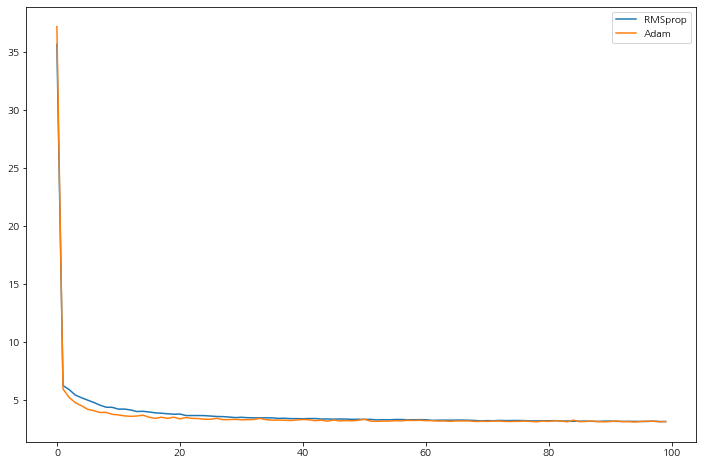

In [1296]:
fig, axe = plt.subplots(figsize = (12,8))
axe.plot(h.history['loss'], label = 'RMSprop')
axe.plot(w.history['loss'], label = 'Adam')
axe.legend()

In [1333]:
test = temp_real['평균기온(℃)']
test = {0 : test}
test = pd.DataFrame(test)
print(test)

            0
0     1.88125
1    -0.58750
2    -1.09375
3     0.63750
4     1.57500
..        ...
217  29.40625
218  29.28750
219  29.08125
220  26.48125
221  23.74375

[222 rows x 1 columns]


In [1334]:
df_test = np.array(train.iloc[-1, :].shift(1)).reshape(1,7)

In [1335]:
df_test = pd.DataFrame(df_test)

In [1336]:
df = pd.concat((df_test, test), axis = 0)
df = df.reset_index(drop = True)
df.head()

,0,1,2,3,4,5,6
0,NaN,1.05625,0.53125,-0.5125,0.1625,0.3125,-0.89375
1,1.88125,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.58750,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.09375,NaN,NaN,NaN,NaN,NaN,NaN
4,0.63750,NaN,NaN,NaN,NaN,NaN,NaN


In [1337]:
def maketimeSeries(df, n_in = 6):
    for i in range(1, n_in+1):
        df[i] = df[i-1].shift(1)
    return df

In [1338]:
def maketest(df):
    for i in range(0, len(df) - 1):
        df.iloc[i, 0] = df.iloc[i+1, 0]
        df.iloc[i+1, :] = df.iloc[i].shift(1)
    return df

In [1339]:
test = maketest(df)

In [1340]:
test

,0,1,2,3,4,5,6
0,1.88125,1.05625,0.53125,-0.51250,0.16250,0.31250,-0.89375
1,-0.58750,1.88125,1.05625,0.53125,-0.51250,0.16250,0.31250
2,-1.09375,-0.58750,1.88125,1.05625,0.53125,-0.51250,0.16250
3,0.63750,-1.09375,-0.58750,1.88125,1.05625,0.53125,-0.51250
4,1.57500,0.63750,-1.09375,-0.58750,1.88125,1.05625,0.53125
...,...,...,...,...,...,...,...
218,29.28750,29.40625,30.07500,30.02500,29.82500,29.41875,29.27500
219,29.08125,29.28750,29.40625,30.07500,30.02500,29.82500,29.41875
220,26.48125,29.08125,29.28750,29.40625,30.07500,30.02500,29.82500
221,23.74375,26.48125,29.08125,29.28750,29.40625,30.07500,30.02500


In [1341]:
X_test = test.iloc[:-1, 1:]
y_test = test.iloc[:-1, 0]

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0], 1)

In [1342]:
m_lstm_RMS = tf.keras.models.load_model('m_lstm.h5')
m_lstm_Adam = tf.keras.models.load_model('m_lstm_adam.h5')

In [1343]:
m_lstm_Adam.evaluate(X_train, y_train)
m_lstm_RMS.evaluate(X_train, y_train)

114/114 [==============================] - 0s 809us/step - loss: 3.0257 - mae: 1.2665


[3.0256593227386475, 1.2665188312530518]

In [1344]:
m_lstm_Adam.evaluate(X_test, y_test)
m_lstm_RMS.evaluate(X_test, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 3.2576 - mae: 1.3268


[3.2576019763946533, 1.3268487453460693]

In [1363]:
a = np.array(test.iloc[-1, 1:]).reshape(1,6)
next_pred = m_lstm_RMS.predict(a).reshape(1)
next_pred.shape

1/1 [==============================] - 0s 15ms/step


(1,)

In [1359]:
pred = m_lstm_RMS.predict(X_test).reshape(222,)
pred.shape

7/7 [==============================] - 0s 947us/step


(222,)

Text(0.5, 1.0, 'test data : 대한민국 국내 기온 변화 (2023-01-01 ~ 2023-08-10)')

/usr/lib/python3/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


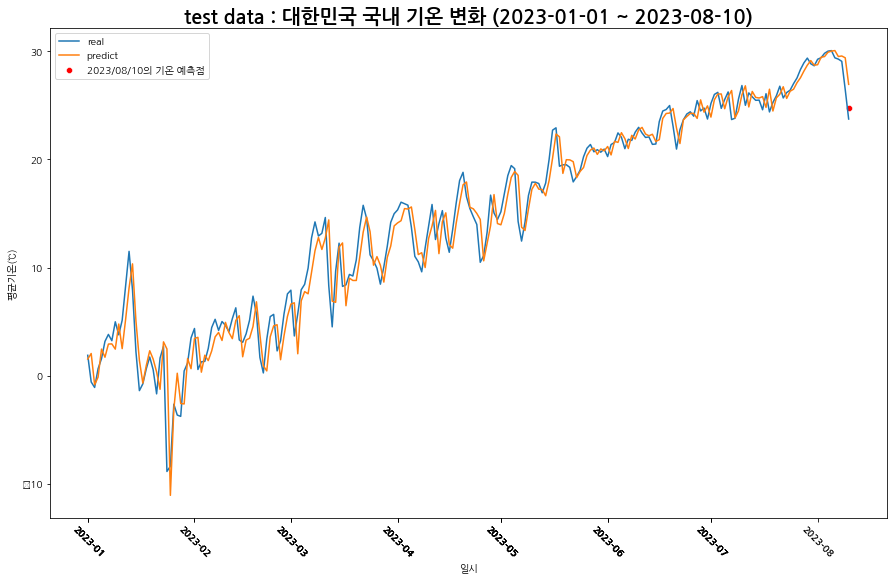

In [1377]:
fig, axe = plt.subplots(figsize = (15,9))
window = 10
sns.lineplot(x = temp_real['일시'], y = temp_real['평균기온(℃)'], label = 'real')
sns.lineplot(x = temp_real['일시'], y = pred, label = 'predict')
sns.scatterplot(x = temp_real['일시'].iloc[-1], y = next_pred, color = 'r', marker = 'o', label = '2023/08/10의 기온 예측점')
axe.set_xticks(temp_real['일시'].dt.strftime('%Y-%m').iloc[window::10])
axe.set_xticklabels(temp_real['일시'].dt.strftime('%Y-%m').iloc[window::10], rotation = -45, weight='bold')
axe.set_title('test data : 대한민국 국내 기온 변화 (2023-01-01 ~ 2023-08-10)', fontsize = 20, weight='bold')